# Hirsch indices from Google Scholar

What's going on with the Google Scholar indices
(h5-index or `h5`, h5-median or `m5`)
of the journals in the SciELO network
for each subject area?

In [1]:
from collections import Counter
from itertools import accumulate, chain
from statistics import median

In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
pd.options.display.max_colwidth = 400
pd.options.display.max_rows = 150
%matplotlib inline

## Loading the dataset

Let's load the dataset with all journals in the SciELO network.

In [4]:
journals = pd.read_csv("tabs_network/journals.csv")

### Column normalization

These are the column names in the raw CSV file:

In [5]:
journals.columns

Index(['extraction date', 'study unit', 'collection', 'ISSN SciELO', 'ISSN's',
       'title at SciELO', 'title thematic areas',
       'title is agricultural sciences', 'title is applied social sciences',
       'title is biological sciences', 'title is engineering',
       'title is exact and earth sciences', 'title is health sciences',
       'title is human sciences', 'title is linguistics, letters and arts',
       'title is multidisciplinary', 'title current status',
       'title + subtitle SciELO', 'short title SciELO', 'short title ISO',
       'title PubMed', 'publisher name', 'use license', 'alpha frequency',
       'numeric frequency (in months)', 'inclusion year at SciELO',
       'stopping year at SciELO', 'stopping reason',
       'date of the first document', 'volume of the first document',
       'issue of the first document', 'date of the last document',
       'volume of the last document', 'issue of the last document',
       'total of issues', 'issues at 2018', 'is

The column names aren't helping us with all the small details
like the trailing whitespace
in the fields whose name starts with `google scholar`.
The easiest approach is to run this normalization function
from the column names simplification notebook:

In [6]:
def normalize_column_title(name):
    import re
    name_unbracketed = re.sub(r".*\((.*)\)", r"\1",
                              name.replace("(in months)", "in_months"))
    words = re.sub("[^a-z0-9+_ ]", "", name_unbracketed.lower()).split()
    ignored_words = ("at", "the", "of", "and", "google", "scholar", "+")
    replacements = {
        "document": "doc",
        "documents": "docs",
        "frequency": "freq",
        "language": "lang",
    }
    return "_".join(replacements.get(word, word)
                    for word in words if word not in ignored_words) \
              .replace("title_is", "is")

Applying it is straightforward, and the order of the columns is kept as is.

In [7]:
journals.rename(columns=normalize_column_title, inplace=True)
journals.columns

Index(['extraction_date', 'study_unit', 'collection', 'issn_scielo', 'issns',
       'title_scielo', 'title_thematic_areas', 'is_agricultural_sciences',
       'is_applied_social_sciences', 'is_biological_sciences',
       'is_engineering', 'is_exact_earth_sciences', 'is_health_sciences',
       'is_human_sciences', 'is_linguistics_letters_arts',
       'is_multidisciplinary', 'title_current_status', 'title_subtitle_scielo',
       'short_title_scielo', 'short_iso', 'title_pubmed', 'publisher_name',
       'use_license', 'alpha_freq', 'numeric_freq_in_months',
       'inclusion_year_scielo', 'stopping_year_scielo', 'stopping_reason',
       'date_first_doc', 'volume_first_doc', 'issue_first_doc',
       'date_last_doc', 'volume_last_doc', 'issue_last_doc', 'total_issues',
       'issues_2018', 'issues_2017', 'issues_2016', 'issues_2015',
       'issues_2014', 'issues_2013', 'total_regular_issues',
       'regular_issues_2018', 'regular_issues_2017', 'regular_issues_2016',
       'regul

### Thematic areas

Based on the thematic area normalization notebook,
these are the columns for each thematic area
after column name normalization:

In [8]:
areas_map = {
    "Agricultural Sciences": "is_agricultural_sciences",
    "Applied Social Sciences": "is_applied_social_sciences",
    "Biological Sciences": "is_biological_sciences",
    "Engineering": "is_engineering",
    "Exact and Earth Sciences": "is_exact_earth_sciences",
    "Health Sciences": "is_health_sciences",
    "Human Sciences": "is_human_sciences",
    "Linguistics, Letters and Arts": "is_linguistics_letters_arts",
}
areas = list(areas_map.values())
areas

['is_agricultural_sciences',
 'is_applied_social_sciences',
 'is_biological_sciences',
 'is_engineering',
 'is_exact_earth_sciences',
 'is_health_sciences',
 'is_human_sciences',
 'is_linguistics_letters_arts']

One missing is the `is_multidisciplinary`,
which is $1$
if the journal has at least $3$ of the distinct thematic areas above,
otherwise it's $0$.

In [9]:
areaswm = areas + ["is_multidisciplinary"]

### Normalization

We'll need the ISSN and the thematic areas,
so these should be normalized.
The code below follows the normalization notebooks for these fields.

In [10]:
# ISSN normalization
issn_scielo_fix = {"0001-6002": "0001-6012",
                   "0258-6444": "2215-3535",
                   "0325-8203": "1668-7027",
                   "0719-448x": "0719-448X",
                   "0797-9789": "1688-499X",
                   "0807-8967": "0870-8967",
                   "0858-6444": "0258-6444",
                   "1315-5216": "1316-5216",
                   "1667-8682": "1667-8982",
                   "1678-5177": "0103-6564",
                   "1683-0789": "1683-0768",
                   "1688-4094": "1688-4221",
                   "1852-4418": "1852-4184",
                   "1980-5438": "0103-5665",
                   "2175-3598": "0104-1282",
                   "2233-7666": "2223-7666",
                   "2237-101X": "1518-3319",
                   "2993-6797": "2393-6797"}
journals["issn_scielo"].replace(issn_scielo_fix, inplace=True)

In [11]:
# Thematic area normalization
tta_map = journals.groupby("issn_scielo").apply(
    lambda df: df.assign(title_thematic_areas=df["title_thematic_areas"]
                                              .replace("Psicanalise",
                                                       "Human Sciences")
                                              .fillna("Human Sciences"),
                         order=df["collection"].isin(["sss", "psi"]) |
                               (df["title_thematic_areas"] == "Psicanalise") |
                               df["title_thematic_areas"].isna())
                 .sort_values("order")["title_thematic_areas"].iloc[0]
)
tta_text_n = journals["issn_scielo"].map(tta_map) \
                                    .rename("title_thematic_areas")
tta_list_n = tta_text_n.str.split(";")
tta_n = pd.DataFrame(tta_text_n).assign(**{
    area: tta_list_n.apply((lambda n: lambda entries: int(n in entries))(name))
    for name, area in areas_map.items()
}).assign(is_multidisciplinary=lambda df: (df[areas].sum(axis=1) >= 3).map(int))
journals = journals.assign(**tta_n)

### Selecting the Google Scholar fields

The fields regarding to the h5/m5 indices from Google Scholar are:

In [12]:
h5_fields = sorted(k for k in journals.columns if k.startswith("h5"))
m5_fields = sorted(k for k in journals.columns if k.startswith("m5"))
h5_fields, m5_fields

(['h5_2013', 'h5_2014', 'h5_2015', 'h5_2016', 'h5_2017', 'h5_2018'],
 ['m5_2013', 'm5_2014', 'm5_2015', 'm5_2016', 'm5_2017', 'm5_2018'])

Are the h5/m5 fields consistent?

In [13]:
h5m5_inconsistency = journals.groupby("issn_scielo")[h5_fields + m5_fields] \
    .apply(lambda df: df.apply(lambda col: set(col.dropna())).apply(len).max() > 1)
h5m5_inconsistency[h5m5_inconsistency]

Series([], dtype: bool)

Yes, they are!
The only requirement we have regarding these fields
is to ignore any possible `NaN` values.

Does every column have information?

In [14]:
h5m5_is_empty = journals[h5_fields + m5_fields].count() == 0
h5m5_empty_list = list(h5m5_is_empty[h5m5_is_empty].index)
h5m5_empty_list

['h5_2018', 'm5_2018']

No! These two empty columns shown above have no use for us.

In [15]:
h5_fields = [k for k in h5_fields if k not in h5m5_empty_list]
m5_fields = [k for k in m5_fields if k not in h5m5_empty_list]
gs_fields = list(chain(*zip(h5_fields, m5_fields)))
gs_fields

['h5_2013',
 'm5_2013',
 'h5_2014',
 'm5_2014',
 'h5_2015',
 'm5_2015',
 'h5_2016',
 'm5_2016',
 'h5_2017',
 'm5_2017']

### Data de-duplication (building the dataset)

A missing normalization step regards to this issue:
there should be no more than a single entry for each journal.
Since there are many journals that in more than one collection,
we have data duplication.
The normalization step already enforced
that any of these rows have the same thematic area,
besides a common `issn_scielo` that can be regarded as its *primary key*.
As we've seen in the Google Scholar indices section,
the indices are consistent, as long as we coalesce the `NaN` entries.

Now that we're aware of that, let's remove the duplicate entries.

The renamed columns we'll need are
(these names are the ones after the renaming step):

In [16]:
columns = ["issn_scielo"] + gs_fields + areaswm
columns

['issn_scielo',
 'h5_2013',
 'm5_2013',
 'h5_2014',
 'm5_2014',
 'h5_2015',
 'm5_2015',
 'h5_2016',
 'm5_2016',
 'h5_2017',
 'm5_2017',
 'is_agricultural_sciences',
 'is_applied_social_sciences',
 'is_biological_sciences',
 'is_engineering',
 'is_exact_earth_sciences',
 'is_health_sciences',
 'is_human_sciences',
 'is_linguistics_letters_arts',
 'is_multidisciplinary']

Since everything is already normalized,
getting the dataset is straightforward:

In [17]:
dataset = journals[columns].groupby("issn_scielo").agg("max")
dataset.head().T

issn_scielo,0001-3714,0001-3765,0001-6012,0001-6365,0002-0591
h5_2013,NaN,19.0,NaN,NaN,3.0
m5_2013,NaN,28.0,NaN,NaN,5.0
h5_2014,NaN,19.0,NaN,NaN,3.0
m5_2014,NaN,31.0,NaN,NaN,5.0
h5_2015,NaN,19.0,NaN,NaN,4.0
m5_2015,NaN,24.0,NaN,NaN,4.0
h5_2016,NaN,18.0,6.0,NaN,5.0
m5_2016,NaN,25.0,7.0,NaN,5.0
h5_2017,NaN,16.0,7.0,NaN,5.0
m5_2017,NaN,19.0,11.0,NaN,6.0


There's a lot of `NaN`s!
Let's see what we can do with that information.

## Understanding the Hirsch index

The dataset is ready,
but before we start exploring the data,
it makes sense to know
what's the meaning of the Google Scholar indices columns.

### Definition

In the
[Google Scholar top publications web page](https://scholar.google.com/citations?view_op=top_venues)
we can see the definition of the *h5-index* and *h5-median*
(the `h5_*` and `m5_*` columns of the dataset, respectively).
It defines:

> h5-index is the h-index for articles published in the last 5 complete years. It is the largest number h such that h articles published in 2013-2017 have at least h citations each.

> h5-median for a publication is the median number of citations for the articles that make up its h5-index.

The Hirsch index for a graph is:

$$
h_{journal} =
  \max_{node_i \in journal} \left\{
    \min \left[
      \operatorname{in-degree}(node_i),
      \sum_{\substack{
        node_j \in journal \\
        \operatorname{in-degree}(node_j) \ge
        \operatorname{in-degree}(node_i)
      }} 1
    \right]
  \right\}
$$

Where the Google Scholar's `h5-index` is just the Hirsch index for a journal
in the directed graph of articles (nodes) connected by citations (edges)
in the last completed $5$ years,
including the edges coming from other journals.
The *in-degree* of an article
is the number of citations it received in the network.

And, by the above definition, the Google Scholar's `h5-median` is:

$$
\underset{_{\substack{
  node_i \in journal \\
  \operatorname{in-degree}(node_i) \ge h_{journal}
}}}{\operatorname{median}}
\left[ \operatorname{in-degree}(node_i) \right]
$$

Which means that $\text{h5-median} \ge \text{h5-index}$.

### Simplified explanation of the Hirsch index definition

The mathematical definition of the index might *look* complicated,
but thinking on it iteratively
and avoiding the graph theory jargon (*degree* and *node*)
might make its logic quite straightforward:

* The context is the citation network of all articles
  from $2013$ to $2017$ in Google Scholar.
* Let's select the nodes of a specific journal $J$;
* The Hirsch index couldn't be less than $0$, so let's say it's at least $0$;
* Is there at least $1$ article from $J$
  receiving at least $1$ citation in the network?
  If yes, then the Hirsch index is at least $1$;
* Are there at least $2$ articles from $J$
  receiving at least $2$ citations in the network?
  If yes, then the Hirsch index is at least $2$;
* ...
* Are there at least $h$ articles from $J$
  receiving at least $h$ citations in the network?
  If yes, then the Hirsch index is at least $h$;
* Are there at least $h+1$ articles from $J$
  receiving at least $h+1$ citations in the network?
  If not, then the Hirsch index is smaller than $h+1$,
  and since it's a whole number,
  it's the last ceiling we've found: $h$.


### Implementation using a NetworkX directed graph

Given the citation graph as an instance of `nx.DiGraph`
and a selected set of nodes
(the journal's articles in the graph),
the following functions calculate the `h5-index` and `h5-median`.

In [18]:
def h_index(graph, nodes=None):
    if nodes is None:
        nodes = graph.nodes
    degree_counts = Counter(degree for node, degree in graph.in_degree
                                   if node in nodes)
    degrees, counts = zip(*sorted(degree_counts.items(), reverse=True))
    cum_counts = accumulate(counts)
    return max(min(degree, cc) for degree, cc in zip(degrees, cum_counts))

In [19]:
def h_median(graph, nodes=None, h=None):
    if nodes is None:
        nodes = graph.nodes
    if h is None:
        h = h_index(graph, nodes)
    return median(degree for node, degree in graph.in_degree
                         if node in nodes and degree >= h)

By default, these functions use all nodes in the graph,
and since the median calculation depends on the Hirsch index,
it's also an optional input (by default, it'll calculate the index).

### Example

This dataset doesn't have a full citation graph
including citations from external journals,
so we will just create arbitrary/random graphs
as examples for the calculation of these indices.

Suppose we have a citation network of a single journal,
like this:

h5-index: 1
h5-median: 2.5


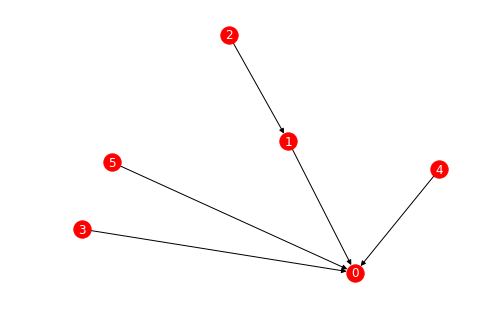

In [20]:
arbitrary_citation_graph = nx.DiGraph([(1, 0), (2, 1), (3, 0), (4, 0), (5, 0)])
nx.draw(arbitrary_citation_graph,
        pos=nx.spring_layout(arbitrary_citation_graph, random_state=42),
        font_color="w",
        with_labels=True)
print(f"h5-index: {h_index(arbitrary_citation_graph)}")
print(f"h5-median: {h_median(arbitrary_citation_graph)}")

The number of citations for each numbered node from $0$ to $5$ is:

In [21]:
[degree for node, degree in sorted(arbitrary_citation_graph.in_degree)]

[4, 1, 0, 0, 0, 0]

The Hirsch index couldn't be $2$
as there's only a single article with more than a single citation.

Another example:

h5-index: 2
h5-median: 4


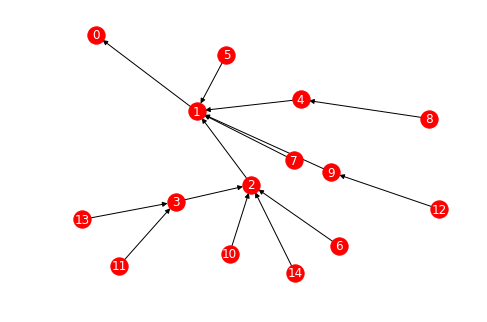

In [22]:
random_citation_graph = nx.gn_graph(15, seed=0)
nx.draw(random_citation_graph,
        pos=nx.spring_layout(random_citation_graph, random_state=42),
        font_color="w",
        with_labels=True)
print(f"h5-index: {h_index(random_citation_graph)}")
print(f"h5-median: {h_median(random_citation_graph)}")

For each numbered node sorted in ascending order,
the number of citations is:

In [23]:
[degree for node, degree in sorted(random_citation_graph.in_degree)]

[1, 5, 4, 2, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]

The only entries greater or equal to $2$ (the Hirsch index)
are $[5, 4, 2]$, whose median is $4$.
If that entry with $2$ citations had been received $3$ citations instead,
this graph would have an Hirsch index of $3$.

Let the even and odd indexed nodes be from two distinct journals,
then this analysis of each journal would be:

* $[1, 4, 1, 0, 0, 0, 0, 0]$ citations for each article,
  $\text{h5-index} = 1$ and $\text{h5-median} = 1$;
* $[5, 2, 0, 0, 1, 0, 0]$ citations for each article,
  $\text{h5-index} = 2$ and $\text{h5-median} = 3.5$.

## Exploratory data analysis

Though we have information about every thematic area,
we don't have the Google Scholar indices
for all the documents/articles:

In [24]:
print(dataset.shape)
dataset.count()

(1642, 19)


h5_2013                         265
m5_2013                         265
h5_2014                         266
m5_2014                         266
h5_2015                         803
m5_2015                         803
h5_2016                         772
m5_2016                         772
h5_2017                         923
m5_2017                         923
is_agricultural_sciences       1642
is_applied_social_sciences     1642
is_biological_sciences         1642
is_engineering                 1642
is_exact_earth_sciences        1642
is_health_sciences             1642
is_human_sciences              1642
is_linguistics_letters_arts    1642
is_multidisciplinary           1642
dtype: int64

The `h5` and `m5` are pairs, having one means we have the other one.

We have that index for $\approx 56.2\%$ of the data in $2017$.

In [25]:
dataset["h5_2017"].count() / dataset.shape[0]

0.5621193666260658

We should emphasize the $2017$ data,
as it has way more information than the remaining of the data.